# Autoencoders for anomaly detection

An autoencoder is trained to detect anomalies on the ECG5000 dataset. This contains 5, 000 electrocardiograms, each with 140 data points. Each example is labeled with either 0 (an abnormal rhythm), or 1 (a normal rhythm).

While this problem could be tackled in a supervised manner (because it is labeled), the goal of this example is to illustrate anomaly detection on larger unlabeled datasets.

An autoencoder is designed to minimise reconsruction error. Therefore, an autoencoder is trained on normal rhythms only and then used to reconstruct these rhythms. When an abnormal rhythm is given to the autoencoder, it is expected the autoencoder will have a higher reconstruction error. This rhythm can then be classified as an anomaly.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Load ECG data

This dataset is based on [timeseriesclassification.com](https://timeseriesclassification.com)

In [30]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [31]:
# last element is the labels
labels = raw_data[:, -1]

# remaining is the electrogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21)

The datasets must be normalised to the range [0, 1] to improve training accuracy.

In [32]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

We only want to train the autoencoder using normal rhythms so separate the normal and abnormal rhythms.

In [33]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normalised ECG with normal rhythm. 

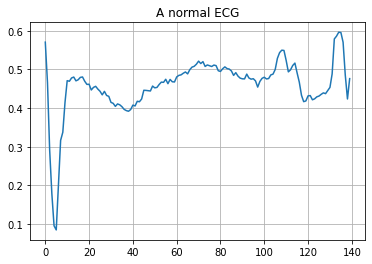

In [34]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('A normal ECG')
plt.show()

Plot a normalised ECG with anomalous rhythm.

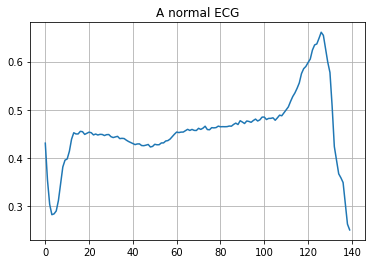

In [35]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title('A normal ECG')
plt.show()

## Build model

Build an autoencoder model to identify anomilous ECG results. An autoencoder architecture is such that it attempts to reconstruct the original input from a compressed representation of the input.

![Autoencoder architecture](./resource/autoencoder-architecture.png)

_Changing the size of the embedding (smallest layer) is worth playing around with._


In [36]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(140, activation='sigmoid')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

## Train model

The autoencoder is trained using only normal ECGs, but is evaluated using the full test set.

In [37]:
history = autoencoder.fit(normal_train_data, 
                          normal_train_data, 
                          epochs=20, 
                          batch_size=512, 
                          validation_data=(test_data, test_data),
                          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 29ms/step - loss: 0.0575 - val_loss: 0.0532
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0549 - val_loss: 0.0522
Epoch 3/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0515 - val_loss: 0.0507
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0479 - val_loss: 0.0484
Epoch 5/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0444 - val_loss: 0.0468
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0413 - val_loss: 0.0448
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0385 - val_loss: 0.0433
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0361 - val_loss: 0.0422
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0339 - val_loss: 0.0408
Epoch 10/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0319 - val_loss: 0.0397
Epoch 11/20
5/5 [===============

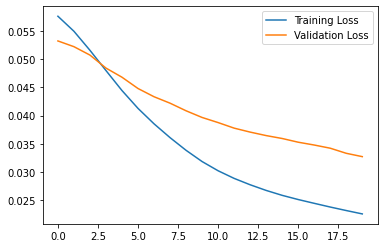

In [38]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

## Evaluate training

We can plot a normal ECG from the training set followed by its reconstruction after its encoded and decoded by the autoencoder. The area between these plots resembles the reconstruction error.

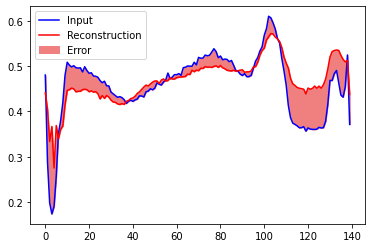

In [39]:
encoded_images = autoencoder.encoder(normal_test_data).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_images[0], 'r')
plt.fill_between(np.arange(140), decoded_images[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

Show a similar plot for anomilous data.

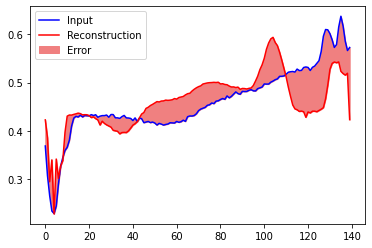

In [40]:
encoded_images = autoencoder.encoder(anomalous_test_data).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_images[0], 'r')
plt.fill_between(np.arange(140), decoded_images[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

## Detect anomalies

We can calculate whether the reconstructioin loss is greater than a fixed threshold. In this example we choose to define anomalous results as being one standard deviation from the training set loss values.

[0.02871504 0.01565396 0.02035884 ... 0.01401164 0.02425129 0.01916016]


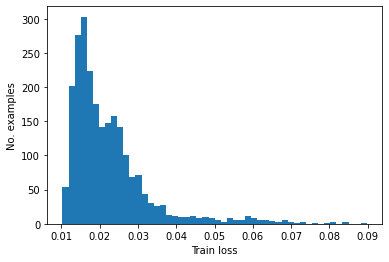

In [50]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data).numpy()

plt.hist(train_loss, bins=50)
plt.xlabel('Train loss')
plt.ylabel('No. examples')
plt.show()

Select a threshold value that is one standard deviation above the mean.

In [51]:
threshold = np.mean(train_loss) + np.std(train_loss)
print('Threshold: ', threshold)

Threshold:  0.03299389


_Other strategies exist for the threshold value. These will be explored later. By varying the threshold value one can adjust the precision and recall of a classifier._

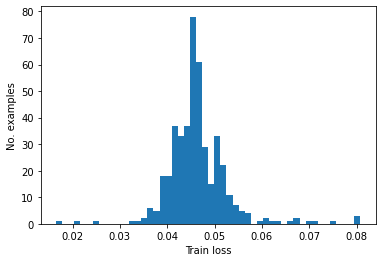

In [54]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data).numpy()

plt.hist(test_loss, bins=50)
plt.xlabel('Train loss')
plt.ylabel('No. examples')
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [56]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold), loss

def print_stats(predictions, labels):
    print(f'Accuracy: {accuracy_score(labels, predictions)}')
    print(f'Precision: {precision_score(labels, predictions)}')
    print(f'Recall: {recall_score(labels, predictions)}')
    
preds, scores = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy: 0.942
Precision: 0.9921568627450981
Recall: 0.9035714285714286


## ROC and AUC metrics

In its current form, the accuracy of the model is highly dependent on the threshold that has been selected. Enter Receiver Operating Characteristic (ROC) plots allow different threshold impacts upon accuracy to be visualised.

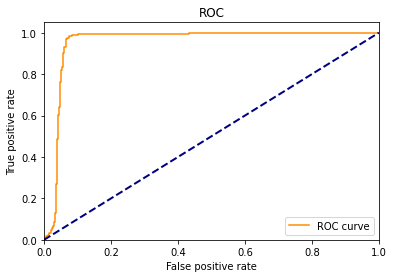

In [57]:
false_positive_rate = []
true_positive_rate = []

flipped_labels = 1 - test_labels  # because anomalies are labeled with 1.
false_positive_rate, true_positive_rate, _ = roc_curve(flipped_labels, scores)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

Since the threshold value is subjective, we may want to compare models without factoring in this value. We can do this by measuring the area under the curve (AUC) in the ROC plot.

In [58]:
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.9546185064935064
